<a href="https://colab.research.google.com/github/carvalheirafc/deep_learning_stuff/blob/master/mlp/diabetes/task3/feed_foward_and_back_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics

import matplotlib.pyplot as plt

import tensorflow as tf

In [18]:
csv_file = 'https://raw.githubusercontent.com/carvalheirafc/deep_learning_stuff/master/mlp/diabetes/diabetes_pca_result.csv'
df = pd.read_csv(csv_file)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Component 1,768.0,-6.693141e-17,1.711960,-5.587340,-1.027072,0.152931,1.095689,5.963579
Component 2,768.0,-6.071532e-17,1.318184,-2.955806,-1.007096,-0.225966,0.959128,3.606582
Component 3,768.0,-3.324887e-17,1.015629,-3.203088,-0.646496,-0.103940,0.549774,4.754503
Component 4,768.0,2.349105e-18,0.966941,-2.192185,-0.664677,-0.115829,0.543242,4.125987
Diagnóstico,768.0,3.489583e-01,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


In [19]:
features = df.drop('Diagnóstico', axis=1).values
target = df['Diagnóstico'].values

print(features.shape)
print(target.shape)

(768, 4)
(768,)


In [20]:
k_fold = KFold(n_splits=20)

X_train = []
X_test = []
y_train = []
y_test = []
for train_indices, test_indices in k_fold.split(features, target):
  for ii in train_indices:
    X_train.append( features[ii] )
    y_train.append( target[ii] )
  for jj in test_indices:
    X_test.append( features[jj] )
    y_test.append( target[jj] )

#X_train, X_test, y_train, y_test = train_test_split(features, 
#                                                    target, 
#                                                    test_size=0.2, 
#                                                    random_state=666)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(14592, 4)
(768, 4)
(14592,)
(768,)


In [0]:
labels_train = (np.arange(2) == y_train[:,None]).astype(np.float64)
labels_test = (np.arange(2) == y_test[:,None]).astype(np.float64)


In [0]:
inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
label = tf.placeholder(tf.float32, shape=(None, 2), name='labels')

In [0]:
# Feed batch data
def get_batch(inputX, inputY, batch_size):
   duration = len(inputX)
   for i in range(0,duration//batch_size):
     idx = i*batch_size
     yield inputX[idx:idx+batch_size], inputY[idx:idx+batch_size]

In [0]:
def feed_foward_network(data):
  
  hidden_size_one = 128
  hidden_size_two = 256
  
  # First layer
  weight_one = tf.Variable(tf.random_normal([hidden_size_one, X_train.shape[1]], stddev=0.01), name='weight_one')
  bias_one = tf.Variable(tf.constant(0.1, shape=(hidden_size_one, 1)), name='bias_one')
  y_one = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(weight_one, tf.transpose(inputs)), bias_one)), keep_prob=0.5)
  
  # Second layer
  weight_two = tf.Variable(tf.random_normal([hidden_size_two, hidden_size_one], stddev=0.01), name='weight_two')
  bias_two = tf.Variable(tf.constant(0.1, shape=(hidden_size_two, 1)), name='bias_two')
  y_two = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(weight_two, y_one), bias_two)), keep_prob=0.5)
  
  # Output layer
  weight_out = tf.Variable(tf.random_normal([2, hidden_size_two], stddev=0.01), name='weight_out')
  bias_out = tf.Variable(tf.random_normal([2, 1]), name='bias_out')
  y_out = tf.transpose(tf.add(tf.matmul(weight_out, y_two), bias_out))
  
  return (y_out)

In [0]:
batch_size = len(X_train) // 100


In [0]:
y = feed_foward_network(inputs)

# Loss function and optimizer
lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=label))
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
#optimizer = tf.train.AdagradOptimizer(lr).minimize(loss)

# Prediction
pred_label = tf.argmax(y, 1)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
def train():
  
  for learning_rate in [0.05, 0.01]:
    for epoch in range(50):
      avg_cost = 0.0

      
      for x_batch, y_batch in get_batch(X_train, labels_train, batch_size):
        for i in range(x_batch.shape[0]):
          _, c = sess.run([optimizer, loss], feed_dict={lr:learning_rate, inputs:x_batch[i, None], label:y_batch[i, None]})
          avg_cost += c
      avg_cost /= X_train.shape[0]
      if epoch % 10 == 0:
        print("Epoch: {:3d}    Train Cost: {:.4f}".format(epoch, avg_cost))
  
  return(c)

In [27]:
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(init)

train()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:   0    Train Cost: 0.5778
Epoch:  10    Train Cost: 0.5476
Epoch:  20    Train Cost: 0.5412
Epoch:  30    Train Cost: 0.5393
Epoch:  40    Train Cost: 0.5396
Epoch:   0    Train Cost: 0.5255
Epoch:  10    Train Cost: 0.5152
Epoch:  20    Train Cost: 0.5047
Epoch:  30    Train Cost: 0.5041
Epoch:  40    Train Cost: 0.5024


0.12738952

In [28]:
acc_train = accuracy.eval(feed_dict={inputs: X_train, label: labels_train})
print("Train accuracy: {:3.2f}%".format(acc_train*100.0))

acc_test = accuracy.eval(feed_dict={inputs: X_test, label: labels_test})
print("Test accuracy:  {:3.2f}%".format(acc_test*100.0))

Train accuracy: 75.05%
Test accuracy:  74.61%


In [0]:
df_test = pd.DataFrame()
df_test['targets'] = y_test

for i in range(X_test.shape[0]):
  df_test.loc[i, 'pred'] = sess.run(pred_label, feed_dict={inputs: X_test[i, None]}).squeeze()

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(df_test['targets'], df_test['pred'], pos_label=1)
roc = metrics.auc(fpr, tpr)


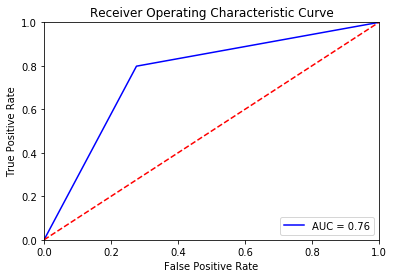

In [31]:
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()